In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

2024-11-08 13:26:29.993279: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-08 13:26:30.065442: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-08 13:26:30.065578: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-08 13:26:30.068348: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-08 13:26:30.079841: I tensorflow/core/platform/cpu_feature_guar

In [2]:
seed = 13
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
train_df = pd.DataFrame({"file" : os.listdir("../data/dogs-vs-cats_241108/train/")})
train_df["label"] = train_df["file"].apply(lambda x : x.split(".")[0])

train_df.head()

,file,label
0,cat.5620.jpg,cat
1,dog.12450.jpg,dog
2,cat.11882.jpg,cat
3,dog.4109.jpg,dog
4,cat.5341.jpg,cat


In [4]:
from sklearn.model_selection import train_test_split 

train_data, val_data = train_test_split(train_df, 
                                        test_size=0.2, 
                                        stratify=train_df["label"], 
                                        random_state=13)

In [5]:
train_datagen = ImageDataGenerator(
    rotation_range = 15,
    horizontal_flip = True,
    preprocessing_function = preprocess_input
)

val_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [6]:
FILES = "../data/dogs-vs-cats_241108/"
batch_size = 16
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_data,
    directory = FILES + "train",
    x_col = "file",
    y_col = "label",
    class_mode = "categorical",
    target_size = (224, 224),
    batch_size = batch_size,
    seed = 13,
)

Found 20000 validated image filenames belonging to 2 classes.


In [7]:
val_generator = val_datagen.flow_from_dataframe(
    dataframe = val_data,
    directory = FILES + "train",
    x_col = "file",
    y_col = "label",
    class_mode = "categorical",
    target_size = (224,224),
    batch_size = batch_size,
    seed = 13,
    shuffle = False
)

Found 5000 validated image filenames belonging to 2 classes.


In [8]:
base_model = VGG16(
    weights = "imagenet",
    input_shape = (224,224,3),
    include_top = False
)

2024-11-08 13:26:33.601657: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-08 13:26:33.660444: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-08 13:26:33.660798: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [9]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
for layers in base_model.layers:
    layers.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
def vgg16_pretrained():
    inputs = tf.keras.Input(shape=(224,224,3))
    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)

    outputs = Dense(2, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    return model

In [12]:
tf.keras.backend.clear_session()

In [13]:
model = vgg16_pretrained()
model.compile(loss = "categorical_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 100)               51300     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                6464      
                                                             

In [14]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = "val_loss",
    factor = 0.2,
    patience = 5,
    min_lr = 0.0001
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    patience = 3
)

In [15]:
check_point = tf.keras.callbacks.ModelCheckpoint(
    monitor = 'val_accuracy',
    filepath = "../data/dogs-vs-cats_241108/",
    save_best_only = True,
    save_weights_only = True
)

In [16]:
history = model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 5,
    callbacks = [reduce_lr, early_stopping, check_point]
)

Epoch 1/5


2024-11-08 13:26:36.422569: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-11-08 13:26:40.266702: I external/local_xla/xla/service/service.cc:168] XLA service 0x7575e4915190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-08 13:26:40.266770: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-11-08 13:26:40.279866: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731040000.407931   94757 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 [==============================] - 190s 147ms/step - loss: 0.1545 - accuracy: 0.9498 - val_loss: 0.0494 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 2/5
1250/1250 [==============================] - 164s 131ms/step - loss: 0.0766 - accuracy: 0.9716 - val_loss: 0.0433 - val_accuracy: 0.9852 - lr: 0.0010
Epoch 3/5
1250/1250 [==============================] - 158s 126ms/step - loss: 0.0690 - accuracy: 0.9747 - val_loss: 0.0430 - val_accuracy: 0.9842 - lr: 0.0010
Epoch 4/5
1250/1250 [==============================] - 170s 136ms/step - loss: 0.0578 - accuracy: 0.9801 - val_loss: 0.0435 - val_accuracy: 0.9824 - lr: 0.0010
Epoch 5/5
1250/1250 [==============================] - 154s 123ms/step - loss: 0.0534 - accuracy: 0.9801 - val_loss: 0.0392 - val_accuracy: 0.9836 - lr: 0.0010


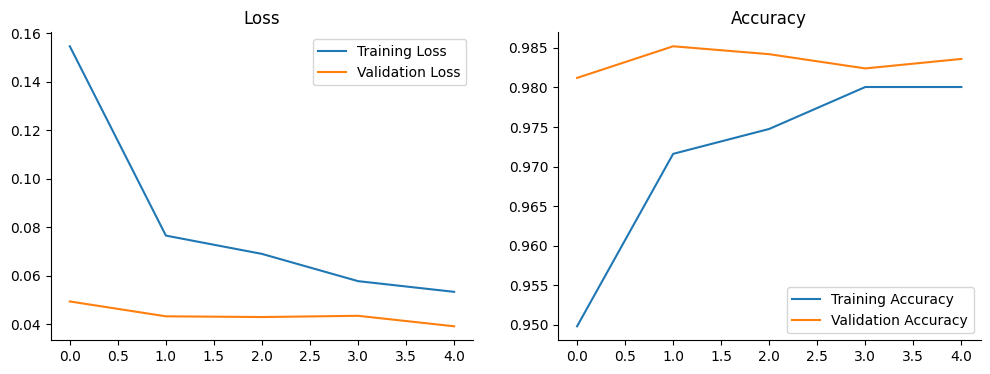

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns.lineplot(x = range(len(history.history["loss"])),
              y = history.history["loss"], ax = axes[0],
              label = "Training Loss")

sns.lineplot(x = range(len(history.history["loss"])),
              y = history.history["val_loss"], ax = axes[0],
              label = "Validation Loss")

sns.lineplot(x = range(len(history.history["accuracy"])),
              y = history.history["accuracy"], ax = axes[1],
              label = "Training Accuracy")

sns.lineplot(x = range(len(history.history["accuracy"])),
              y = history.history["val_accuracy"], ax = axes[1],
              label = "Validation Accuracy")

axes[0].set_title("Loss")
axes[1].set_title("Accuracy")

sns.despine()
plt.show()

In [20]:
val_loss, val_accuracy = model.evaluate(val_generator)

print(f"validation Accuracy: {val_accuracy: .4f}")
print(f"Validation Loss: {val_loss:.4f}")

313/313 [==============================] - 22s 69ms/step - loss: 0.0392 - accuracy: 0.9836
validation Accuracy:  0.9836
Validation Loss: 0.0392


In [25]:
val_pred = model.predict(val_generator)

313/313 [==============================] - 23s 73ms/step


In [26]:
val_data.loc[:,"val_pred"] = np.argmax(val_pred, axis=1)
labels = dict((v, k) for k, v in val_generator.class_indices.items())
val_data.loc[:, "val_pred"] = val_data.loc[:, "val_pred"].map(labels)

val_data.head(10)

/tmp/ipykernel_94624/1072971570.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['cat' 'dog' 'cat' ... 'cat' 'dog' 'dog']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  val_data.loc[:, "val_pred"] = val_data.loc[:, "val_pred"].map(labels)


,file,label,val_pred
7609,cat.6147.jpg,cat,cat
18977,dog.4164.jpg,dog,dog
15548,cat.3181.jpg,cat,cat
12114,dog.8351.jpg,dog,dog
15892,dog.8708.jpg,dog,dog
6710,cat.82.jpg,cat,cat
17298,dog.4125.jpg,dog,dog
957,dog.6018.jpg,dog,dog
17888,cat.6462.jpg,cat,cat
3614,cat.3304.jpg,cat,cat


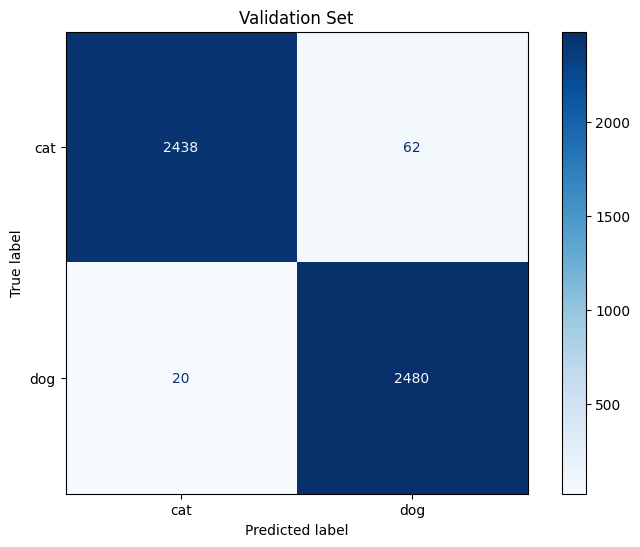

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(9,6))

cm = confusion_matrix(val_data["label"], val_data["val_pred"])
disp = confusion_matrix(val_data["label"], val_data["val_pred"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ["cat", "dog"])
disp.plot(cmap = plt.cm.Blues, ax=ax)

ax.set_title("Validation Set")
plt.show()